# Neural Networks interpretability notebook

In [1]:
#Import statements
import os
import matplotlib.pyplot as plt
import pandas as pd
import shap
import matplotlib.pyplot as plt
from pycaret import classification

### Exploratory data analysis
Import to specify correctly the data path. Initally we can make an easy exploration.

In [2]:
data_folder_path = os.path.join('..', 'data')
data_file = 'ds.csv'

In [3]:
df = pd.read_csv(os.path.join(data_folder_path, data_file))
df.describe()

,Passes,Successful_passes,Unsuccessful_passes,Crosses,Successful_crosses,Unsuccessful_crosses,Long_passes,Long_passes_won,Long_passes_lost,Aerial,...,Saves,Clearances,Shots,Shots_on_target,Shots_off_target,Goals,Goals_from_penalty,Yellow_card,Red_card,gender
count,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,...,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000
mean,15.288562,12.297817,2.990745,0.584243,0.168011,0.416232,1.489796,0.720693,0.769103,1.528002,...,0.161604,0.822259,0.451827,0.150451,0.260797,0.038918,0.005695,0.069293,0.000712,0.641433
std,10.784855,9.956936,2.360398,1.053471,0.468583,0.815517,1.943118,1.158489,1.245770,1.948677,...,0.614128,1.335299,0.790058,0.415866,0.565313,0.199464,0.075261,0.255844,0.026675,0.479637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,10.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,21.000000,17.000000,4.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,70.000000,68.000000,17.000000,9.000000,4.000000,7.000000,16.000000,10.000000,13.000000,15.000000,...,8.000000,11.000000,8.000000,4.000000,5.000000,2.000000,1.000000,2.000000,1.000000,1.000000


### Classification Set-up
Definition of main model hyperparameters. Numeric features and target with full description available.

In [4]:
classification_setup = classification.setup(
    data=df,
    target='gender',
    numeric_features=[c for c in df.columns if c not in ['gender', 'matchPeriod', 'PlayerType']]
)

Setup Succesfully Completed!


,Description,Value
0,session_id,1723
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(4214, 33)"
4,Missing Values,False
5,Numeric Features,30
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Basic multi-level perceptron implementation form Scikit Library. Evaluation with a 10-fold cross validation.

In [5]:
nn_model = classification.create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9492,0.9879,0.9579,0.9630,0.9604,0.8893,0.8894
1,0.9288,0.9781,0.9421,0.9471,0.9446,0.8451,0.8451
2,0.9424,0.9846,0.9683,0.9433,0.9556,0.8735,0.8741
3,0.9356,0.9852,0.9312,0.9670,0.9488,0.8621,0.8632
4,0.9119,0.9759,0.9206,0.9405,0.9305,0.8101,0.8105
5,0.9186,0.9802,0.9630,0.9146,0.9381,0.8196,0.8219
6,0.9424,0.9853,0.9577,0.9526,0.9551,0.8746,0.8746
7,0.9254,0.9787,0.9206,0.9613,0.9405,0.8407,0.8421
8,0.9424,0.9893,0.9524,0.9574,0.9549,0.8751,0.8751
9,0.9388,0.9826,0.9735,0.9340,0.9534,0.8644,0.8659


In [10]:
classification.save_model(nn_model, 'nn_model_19')
nn_model

Transformation Pipeline and Model Succesfully Saved


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=7727, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [6]:
tuned_nn_model = classification.tune_model(nn_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9458,0.9916,0.9526,0.9628,0.9577,0.8822,0.8823
1,0.9186,0.9818,0.9263,0.9462,0.9362,0.8241,0.8244
2,0.9254,0.9872,0.9577,0.9282,0.9427,0.8360,0.8368
3,0.9390,0.9870,0.9312,0.9724,0.9514,0.8696,0.8711
4,0.9220,0.9778,0.9206,0.9560,0.9380,0.8331,0.8342
5,0.9254,0.9835,0.9312,0.9514,0.9412,0.8394,0.8397
6,0.9424,0.9885,0.9524,0.9574,0.9549,0.8751,0.8751
7,0.9254,0.9781,0.9101,0.9718,0.9399,0.8420,0.8451
8,0.9593,0.9939,0.9683,0.9683,0.9683,0.9117,0.9117
9,0.9320,0.9833,0.9524,0.9424,0.9474,0.8512,0.8513


In [12]:
classification.save_model(tuned_nn_model, 'tunned_nn_model_19')
tuned_nn_model

Transformation Pipeline and Model Succesfully Saved


MLPClassifier(activation='relu', alpha=0.2227, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=7727, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### SHAP Kernel Explainer for NN
Implementing SHAP kernel explainer with a 120 sampling.

In [7]:
explainer = shap.KernelExplainer(tuned_nn_model.predict_proba, shap.kmeans(classification_setup[2], 120))

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [8]:
shap_values = explainer.shap_values(classification_setup[3])

In [65]:
len(shap_values)

2

In [29]:
shap.initjs()
#gender (Female = 0, Male = 1)
gender = 0
instance = 10
shap.force_plot(explainer.expected_value[gender], shap_values[gender][instance,:], classification_setup[3].iloc[instance,:])

In [52]:
instance += 1
shap.force_plot(explainer.expected_value[gender], shap_values[gender][instance,:], classification_setup[3].iloc[instance,:])

In [53]:
shap.force_plot(explainer.expected_value[gender], shap_values[gender][instance,:], classification_setup[3].iloc[instance,:], show=False, matplotlib=True).savefig(f"individual_plot_{instance}.png",format = "png",dpi = 300,bbox_inches = 'tight')

In [59]:
shap.summary_plot(shap_values[0], classification_setup[3], max_display=15, show=False)
#plt.show()
plt.savefig("summary_plot.png",format = "png",dpi = 150,bbox_inches = 'tight')

In [321]:
feature = -1

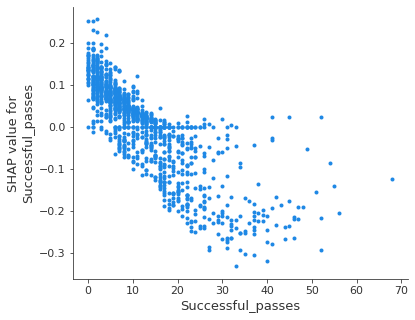

In [323]:
feature += 1
shap.dependence_plot(feature,shap_values[0], classification_setup[3], interaction_index=None, show=False)

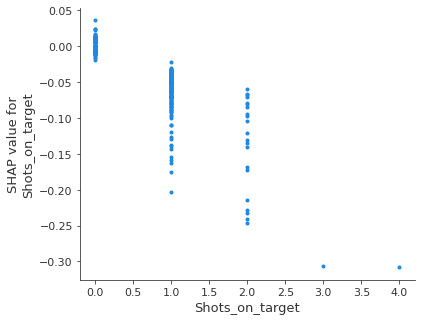

In [314]:
feature_name = classification_setup[3].columns[feature]
shap.dependence_plot(feature,shap_values[0], classification_setup[3], interaction_index=None, show=False)
plt.savefig(f"dependance_{feature_name}.png",format = "png",dpi = 150,bbox_inches = 'tight')